# Introduction

Welcome to the **distil Labs** hands‑on tutorial for fine-tuning and deploying your own domain-specialized model. In this tutorial, you’ll learn how to **Fine-tune a small language model (SLM)** for a custom open-book question answering task using the Distil Labs platform.

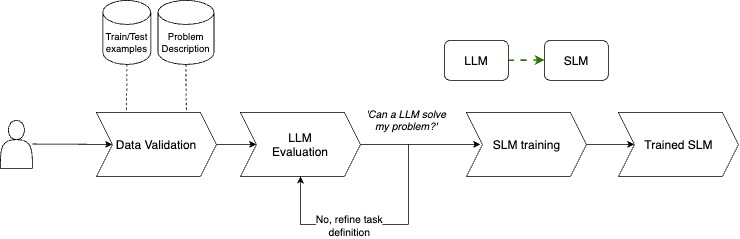

Despite its compact size, the fine-tuned SLM will deliver performance close to much larger models—demonstrating how domain specialization and efficient distillation can unlock powerful capabilities on resource-constrained hardware. By the end, you’ll have a functional, local QA assistant—built with minimal data, no ML expertise, and zero dependency on cloud-based LLMs.

### Registration

The first step towards model distillation is creating an account at [app.distillabs.ai](https://app.distillabs.ai/). Once you sign up, you can use your email/password combination in the authentification section below.

# Notebook Setup

##### Copy over necessary data

In [ ]:
%%bash
# Check if the directory exists
if [ -d "data" ]; then
  echo "Data directory does exist, nothing to do"
else
  echo "Data directory does not exist, cloning from a repository"

  # Clone the repo to a temp location
  git clone https://github.com/distil-labs/distil-labs-examples.git distil-labs-examples

  # Copy the specific subdirectory to the data directory
  cp -r distil-labs-examples/rag-tutorial/data data

  # Delete the cloned repo
  rm -rf distil-labs-examples

  echo "Subdirectory copied and repo removed."

fi

##### Install python libraries

In [ ]:
! pip install langchain-core langchain_community langchain-openai langchain-huggingface langchain-ollama
! pip install wikipedia pandas numpy requests rich pyyaml rouge_score ollama

In [ ]:
%env TOKENIZERS_PARALLELISM=false

Specialize a Question-Answering Model with distil labs

In this chapter you will transform a compact **1B-parameter** “student” model
into a domain expert—without writing a single training loop yourself.
Distil Labs takes care of every heavy-lifting step:

| Stage | What happens under the hood | Why it matters |
| ----- | --------------------------- | -------------- |
| **Data upload & validation** | You submit a *job description*, tiny train / test CSVs, and (optionally) an **unstructured corpus**. The platform checks schema, finds label mistakes, and estimates achievable accuracy. | Catches data bugs before you waste compute. |
| **Teacher evaluation** | A large foundation model (“teacher”) answers your test questions. Distil Labs measures accuracy and shows a pass/fail report. | If the teacher can’t solve the task, small models won’t either—stop here instead of two hours later. |
| **SLM training (synthetic generation + distillation)** | *Automatically* generates additional Q&A pairs from your corpus to fill knowledge gaps, then fine-tunes the 135 M student with LoRA/QLoRA adapters while distilling the teacher’s reasoning. Lightweight hyper-parameter search runs in the background. | Produces a model up to **70 × smaller** than the teacher yet usually within a few percentage points of its accuracy—ready for CPU-only devices. |
| **Benchmarking & packaging** | Once training finishes, Distil Labs re-evaluates both teacher and student on your held-out test set, generates a side-by-side metrics report, and bundles the weights in an Ollama-ready tarball. | You get hard numbers *and* a model you can run locally in one command. |


**What you need to supply**

* A concise *job description* that tells the platform what “good” looks like  
* Roughly **20–100** labeled (question, answer) pairs for train / test  
* Any domain documents you want the teacher to read while inventing synthetic Q&A pairs

Everything else (synthetic generation, distillation, evaluation, and packaging) is automated.  
Let’s dive in and see how that looks in practice.


### Authentication

The first step towards model distillation is logging into your distil labs account you created at the begginning of the notebook. If you registered already, you can use your email/password combination in the authentication section below.

In [ ]:
import getpass
import json
import requests


def distil_bearer_token(DL_USERNAME: str, DL_PASSWORD: str) -> str:
    response = requests.post(
        "https://cognito-idp.eu-central-1.amazonaws.com",
        headers={
            "X-Amz-Target": "AWSCognitoIdentityProviderService.InitiateAuth",
            "Content-Type": "application/x-amz-json-1.1",
        },
        data=json.dumps({
            "AuthParameters": {
                "USERNAME": DL_USERNAME,
                "PASSWORD": DL_PASSWORD,
            },
            "AuthFlow": "USER_PASSWORD_AUTH",
            "ClientId" : "4569nvlkn8dm0iedo54nbta6fd",
        })
    )
    response.raise_for_status()
    return response.json()["AuthenticationResult"]["AccessToken"]


DL_USERNAME = "YOUR_EMAIL"
DL_PASSWORD = getpass.getpass()

AUTH_HEADER = {"Authorization": distil_bearer_token(DL_USERNAME, DL_PASSWORD)}
print("Success")

### Register a new model

The first component of the workflow is registring a new model - this helps us keep track of all our experiments down the line

In [ ]:
## Register a model
from pprint import pprint

# Register a model
data = {"name": "testmodel-123"}
response = requests.post(
    "https://api.distillabs.ai/models",
    data=json.dumps(data),
    headers={"content-type": "application/json", **AUTH_HEADER},
)
pprint(response.json())
model_id = response.json()["id"]
print(f"Registered a model with ID={model_id}")

#### Inspect our models
Now that the model is registerd, we can take a look at all the models in our repository

In [ ]:
from pprint import pprint

# Retrieve all models
response = requests.get(
    "https://api.distillabs.ai/models",
    headers=AUTH_HEADER
)
pprint(response.json())

### Data Upload

The data for this example should be stored in the data_location directory. Lets first take a look at the current directory to make sure all files are available. Your current directory should look like:
```
├── README.md
├── rag-tutorial.ipynb
└── data
    ├── job_description.json
    ├── test.csv
    ├── train.csv
    └── unstructured.csv
```

In [ ]:
import json
from pathlib import Path
import rich.json

with open(Path("data").joinpath("job_description.json")) as fin:
    rich.print(rich.json.JSON(fin.read()))

#### Train/test set

We need a small train dataset to begin distil labs training and a testing dataset that we can use to evaluate the performance of the fine-tuned model. Here, we use the train and test datasets from the data_location directory where each is a CSV file with below 100 (question, answer) pairs.

In [ ]:
from pathlib import Path
from IPython.display import display

import pandas as pd

print("# --- Train set")
train = pd.read_csv(Path("data").joinpath("train.csv"))
display(train)

print("# --- Test set")
test = pd.read_csv(Path("data").joinpath("test.csv"))
display(test)

#### Unstructured dataset
The unstructured dataset is used to guide the teacher model in generating diverse, domain-specific data. In the case of this open-book example, we need to provide a realistic document that would be used as context for question-answering. Here, we use the unstructured datasets from the `data_location/` directory where each is a **JSON**-lines with a single column (`context`).

Let's inspect the available datasets to see the format and a few examples.

In [ ]:
import pandas as pd

unstructured = pd.read_csv(Path("data").joinpath("unstructured.csv"))
display(unstructured)

#### Data upload
We upload our dataset by attaching it to the model we created, this lets us keep all the artifacts in one place

In [ ]:
import json

import requests
import yaml
from pathlib import Path
import pandas

# Specify the config
config = {
    "base": {
        "task": "question-answering-open-book",
    },
    "tuning": {
        "num_train_epochs": 4,
    },
}

# Package your data
data_dir = Path("data")
data = {
    "job_description": {
        "type": "json",
        "content": open(data_dir / "job_description.json", encoding="utf-8").read()
    },
    "train_data": {
        "type": "csv",
        "content": open(data_dir / "train.csv", encoding="utf-8").read()
    },
    "test_data": {
        "type": "csv",
        "content": open(data_dir / "test.csv", encoding="utf-8").read()
    },
    "unstructured_data": {
        "type": "csv",
        "content": open(data_dir / "unstructured.csv", encoding="utf-8").read()
    },
    "config": {
        "type": "yaml",
        "content": yaml.dump(config)
    },
}

# Upload data
response = requests.post(
    f"https://api.distillabs.ai/models/{model_id}/uploads",
    data=json.dumps(data),
    headers={"content-type": "application/json", **AUTH_HEADER},
)
print(response.json())
upload_id = response.json()["id"]

### Teacher Evaluation
Before training an SLM, distil labs validates whether a large language model can solve your task:

In [ ]:
from pprint import pprint

# Start teacher evaluation
data = {"upload_id": upload_id}
response = requests.post(
    f"https://api.distillabs.ai/models/{model_id}/teacher-evaluations",
    data=json.dumps(data),
    headers={"content-type": "application/json", **AUTH_HEADER},
)

pprint(response.json())
teacher_evaluation_id = response.json().get("id")

Poll the status endpoint until it completes, then inspect the quality of generated answers. distil labs shows four scores to tell you how well the “teacher” model answers your test questions. Think of them as different lenses on the same picture—together they give a fuller view than any single number

| Metric                   | What it really asks                                                                                     | How to read it                                                                                                                                                |
| ------------------------ | ------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Exact-Match (Binary)** | “Did the model give *exactly* the same words as the reference answer?”                                  | 1 = perfect match, 0 = anything else. Great for facts that have one correct phrasing, harsh on synonyms. ([Wikipedia][1])                                     |
| **LLM-as-a-Judge**       | “If we let a large language model act as a human grader, does it say this answer is good?”              | Scores reflect semantic quality even when wording differs; handy when many answers are possible. ([Evidently AI][2], [arXiv][3])                              |
| **ROUGE-L**              | “How much word-overlap is there between answer and reference?” (counts the longest common subsequence). | Higher = more shared wording; favours longer answers that reuse reference phrases. Widely used in text-summarisation tests. ([Wikipedia][4])                  |
| **METEOR**               | “Do the two answers share words *or* close synonyms/stems, and is the wording fluent?”                  | Balances precision + recall, rewards correct synonyms, penalises word-salad; often tracks human judgements better than pure overlap metrics. ([Wikipedia][5]) |

---

##### How to interpret a scorecard

* If Exact-Match is low but LLM-as-a-Judge is high, the answers are probably *right but paraphrased*—consider adding those paraphrases to your reference set.
* If all four numbers sag, revisit your job description or give the model more context; the task may be under-specified.

Follow the links above for deeper dives if you want to explore the math or research behind each metric.

[1]: https://en.wikipedia.org/wiki/Language_model_benchmark "Language model benchmark"
[2]: https://www.evidentlyai.com/llm-guide/llm-as-a-judge "LLM-as-a-judge: a complete guide to using LLMs for evaluations"
[3]: https://arxiv.org/abs/2411.15594 "[2411.15594] A Survey on LLM-as-a-Judge - arXiv"
[4]: https://en.wikipedia.org/wiki/ROUGE_%28metric%29 "ROUGE (metric)"
[5]: https://en.wikipedia.org/wiki/METEOR "METEOR"



In [ ]:

from pprint import pprint

response = requests.get(
    f"https://api.distillabs.ai/teacher-evaluations/{teacher_evaluation_id}/status",
    headers=AUTH_HEADER
)
pprint(response.json())


### SLM Training
Once the teacher evaluation completes successfully, start the SLM training:

In [ ]:
import time
from pprint import pprint

# Start SLM training
data = {"upload_id": upload_id}
response = requests.post(
    f"https://api.distillabs.ai/models/{model_id}/training",
    data=json.dumps(data),
    headers={"content-type": "application/json", **AUTH_HEADER},
)

pprint(response.json())
slm_training_job_id = response.json().get("id")

We can analyze the status of the training job using the `jobs` API. The following code snippets displays the current status of the job we started before. When the job is finished (`status=complete`), we can use the `jobs` API again to get the benchmarking result - the accuracy of the LLM and the accuracy of the fine-tuned SLM. We can achieve this using:

In [ ]:
import json
from pprint import pprint
import requests

response = requests.get(
    f"https://api.distillabs.ai/trainings/{slm_training_job_id}/status",
    headers=AUTH_HEADER,
)
pprint(response.json())

When the job is finished (`status=complete`), we can use the `jobs` API again to get the benchmarking result for the base and fine-tuned SLM, using the same four metrics as for the teacher evaluation. We can achieve this using:

In [ ]:
from pprint import pprint

response = requests.get(
    f"https://api.distillabs.ai/trainings/{slm_training_job_id}/evaluation-results",
    headers=AUTH_HEADER,
)

pprint(response.json())


### Download Your Model
You can list all of your models using the cell below. Once training is complete, download the selected model for deployment.

In [ ]:
import json
from pprint import pprint
import requests

response = requests.get(
    f"https://api.distillabs.ai/models",
    headers=AUTH_HEADER,
)
pprint(response.json())

In [ ]:
from pprint import pprint

# Get model download URL
slm_training_job_id = "SELECTED-MODEL"
response = requests.get(
    f"https://api.distillabs.ai/trainings/{slm_training_job_id}/model",
    headers=AUTH_HEADER
)

s3url = response.json()["s3_url"]
pprint(response.json())

In [ ]:
import tarfile
import urllib.request

print("Downloading …")
def status(count, block, total):
    print("\r", f"Downloading: {count * block / total:.1%}", end="")


urllib.request.urlretrieve(
    s3url,
    "model.tar",
    reporthook=status,
)

print("\nUnpacking …")
with tarfile.open("model.tar", mode="r:*") as tar:
    tar.extractall(path=".")


In [ ]:
!ls -lt

# Deploy your fine‑tuned model

Now that we have a small language model fine‑tuned specifically for HotpotQA we can launch a lightweight chat model locally with **ollama**.


#### Install ollama in your own system

To install ollama, follow the instructions from https://ollama.com/download and make sure to enable the serving daemon (via `ollama serve`). Once ready, make sure the app is running by executing the following command (the list should be empty since we have not loaded any models yet):

In [ ]:
! ollama list

#### (Optional) Install ollama for Google Colab
If you are running this notebook in Google Colab, you can install Ollama using the following link

In [ ]:
! curl -fsSL https://ollama.com/install.sh | sh

Once ollama is installed, we should start the application. You can start the daemon with `ollama serve` using `nohup` to make sure it stays in the background.

In [ ]:
! nohup ollama serve &

Make sure the app is running by executing the following command (the list should be empty since we have not loaded any models yet):

In [ ]:
! ollama list

### Register and test the downloaded model 
Once your model is trained, it should be unpacked and registered with ollama. The downloaded model directory already contains everything that is needed and the model can be registed with the command below. Once it is ready, we can test the model with a standard OpenAI interface

In [ ]:
! ollama create model-distillabs -f model/Modelfile

In [ ]:
from openai import OpenAI

client = OpenAI(
    base_url = 'http://localhost:11434/v1',
    api_key='ollama', # required, but unused
)

response = client.chat.completions.create(
  model="model-distillabs",
  messages=[
    {"role": "user", "content": "What day is it?"},
  ],
)
print(response.choices[0].message.content)

In [ ]:
SYSTEM_PROMPT = """
You are a problem solving model working on task_description XML block:

<task_description>
Answer the question using information in the context. Questions require information from more than one paragraph from the context to answer.
</task_description>

You will be given a single task with context in the context XML block and the task in the question XML block
Solve the task in question block based on the context in context block.
Generate only the answer, do not generate anything else
"""

PROMPT_TEMPLATE = """
Now for the real task, solve the task in question block based on the context in context block.
Generate only the solution, do not generate anything else.

<context>
{context}
</context>

<question>
{question}
</question>
"""

def get_prompt(self, question: str, context: str) -> str:
    return [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": PROMPT_TEMPLATE.format(context=context, question=question)},
    ]

### Test our model

In [ ]:
import pandas
from pathlib import Path

data_location = Path("data")
test = pandas.read_csv(data_location.joinpath("test.csv"))

example = test.loc[3]
print(f"context:\n{example['context']}")
print(f"question:\n{example['question']}")
print(f"answer:\n{example['answer']}")


response = client.chat.completions.create(
  model="model-distillabs",
  messages=get_prompt(question=example['question'], context=example['context']),
)
print("\n\nPrediction:", response.choices[0].message.content)
